# SEMANTIC SEGMENTATION ON SAMPLE OF CITYSPACE DATASET (Option 02)

## Importing Libraries


In [ ]:
from tensorflow.keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Mounting the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Loading the images and resizing it

In [ ]:
#Resizing images, if needed
SIZE_X = 256 
SIZE_Y = 256
n_classes=12 #Number of classes for segmentation

path_train="/content/gdrive/MyDrive/Colab Notebooks/dataset1/images_prepped_train/"

#Capture training image info as a list
train_images = []
images_path = []

for directory_path in glob.glob(path_train):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        images_path.append(img_path) 
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

path_train_mask="/content/gdrive/MyDrive/Colab Notebooks/dataset1/annotations_prepped_train/"

#Capture mask/label info as a list
train_masks = [] 
masks_path = []

for directory_path in glob.glob(path_train_mask):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        masks_path.append(mask_path)
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [ ]:
print(train_images.shape)
# print(train_masks)
#print(test_images.shape,test_masks.shape)

(367, 256, 256)


## Function to manually Augment Images

In [ ]:
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip
from tqdm import tqdm

def augment_data(images, masks, save_path, augment=True):
    H = 256
    W = 256

    s_images = []
    s_masks = []

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        """ Extracting the name and extension of the image and the mask. """
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]

        """ Reading image and mask. """
        x = cv2.imread(x, 0)
        x = cv2.resize(x, (H, W))
        y = cv2.imread(y, 0)
        y = cv2.resize(y, (H, W),interpolation = cv2.INTER_NEAREST)


        """ Augmentation """
        if augment == True:
            aug = CenterCrop(H, W, p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = RandomRotate90(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            aug = GridDistortion(p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            save_images = [x, x1, x2, x3, x4, x5]
            save_masks =  [y, y1, y2, y3, y4, y5]

            # print(np.array(y))
            s_images.append(x)
            s_images.append(x1)
            s_images.append(x2)
            s_images.append(x3)
            s_images.append(x4)
            s_images.append(x5)

            s_masks.append(y)
            s_masks.append(y1)
            s_masks.append(y2)
            s_masks.append(y3)
            s_masks.append(y4)
            s_masks.append(y5)

        else:
            save_images = [x]
            save_masks = [y]

        """ Saving the image and mask. """
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(images) == 1:
                tmp_img_name = f"{image_name}.{image_extn}"
                tmp_mask_name = f"{mask_name}.{mask_extn}"
            else:
                tmp_img_name = f"{image_name}_{idx}.{image_extn}"
                tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"

            image_path = os.path.join(save_path, "images", tmp_img_name)
            mask_path = os.path.join(save_path, "masks", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1
    return s_images,s_masks
#print(f"Augmented Images: {len(images)} - Augmented Masks: {len(masks)}")

## Augmenting Images

In [ ]:
path_aug="/content/gdrive/MyDrive/Colab Notebooks/dataset1/new_data/"
s_images,s_masks=augment_data(images_path, masks_path, path_aug, augment=True)

100%|██████████| 367/367 [00:07<00:00, 49.24it/s]


In [ ]:
#Loading augmented images and masks.
#images, masks = load_data(path_aug)
s_images=np.array(s_images)
s_masks=np.array(s_masks)

train_images=s_images
train_masks=s_masks
print(s_masks.shape,train_masks.shape)
#print(s_masks)

(2202, 256, 256) (2202, 256, 256)


## Encoding Labels into Mask Images

In [ ]:
#Encode labels
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

print(train_images.shape)

(367, 256, 256, 1)


In [ ]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
#X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Class values in the dataset are ...  [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [ ]:
print(train_masks_reshaped_encoded)

[1 1 1 ... 3 3 3]


## Calculating Class Weights

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(train_masks_reshaped_encoded),
                                                 y = train_masks_reshaped_encoded)
#class_weights=np.array(class_weights)

class_weights1 = {0: class_weights[0],
                1: class_weights[1],
                2: class_weights[2],
                3: class_weights[3],
                4: class_weights[4],
                5: class_weights[5],
                6: class_weights[6],
                7: class_weights[7],
                8: class_weights[8],
                9: class_weights[9],
                10: class_weights[10],
                11: class_weights[11]}

print("Class weights are...:", class_weights1)


Class weights are...: {0: 0.49103854139309294, 1: 0.3578442627409378, 2: 8.399199321686341, 3: 0.2647881411892111, 4: 1.8544700109209329, 5: 0.8547369097386731, 6: 7.0986443587355215, 7: 7.388804714735638, 8: 1.4190714823633475, 9: 13.044897286203657, 10: 28.499855437219466, 11: 2.1209241033053727}


In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

# OPTION 02

## Architecture 01- Baseline Network U-NET

### Developing the Model

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

# IMG_HEIGHT=256
# IMG_WIDTH=256

#Build the model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
s = inputs

#Downsampling
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)
    
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)
     
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
     
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
#Upsampling 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
model = Model(inputs=[inputs], outputs=[outputs])

### Compiling the model and defining the optimizer,loss and metrics

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

### Fitting the created U-NET model

In [ ]:
print(X_train.shape)

(330, 256, 256, 1)


In [ ]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False
                    )
                    


model.save('test.hdf5')

Epoch 1/50
11/11 [==============================] - 26s 1s/step - loss: 2.4543 - accuracy: 0.1469 - val_loss: 2.3759 - val_accuracy: 0.1687
Epoch 2/50
11/11 [==============================] - 7s 656ms/step - loss: 2.2625 - accuracy: 0.1766 - val_loss: 2.1722 - val_accuracy: 0.2175
Epoch 3/50
11/11 [==============================] - 7s 654ms/step - loss: 2.0900 - accuracy: 0.2143 - val_loss: 2.0391 - val_accuracy: 0.1828
Epoch 4/50
11/11 [==============================] - 7s 657ms/step - loss: 2.0035 - accuracy: 0.1941 - val_loss: 2.0005 - val_accuracy: 0.2241
Epoch 5/50
11/11 [==============================] - 7s 658ms/step - loss: 1.9489 - accuracy: 0.2101 - val_loss: 1.9413 - val_accuracy: 0.1935
Epoch 6/50
11/11 [==============================] - 7s 662ms/step - loss: 1.9110 - accuracy: 0.2680 - val_loss: 1.9037 - val_accuracy: 0.3524
Epoch 7/50
11/11 [==============================] - 8s 689ms/step - loss: 1.8704 - accuracy: 0.3362 - val_loss: 1.8460 - val_accuracy: 0.3582
Epoch 8/

### Evaluating the model

#### 1. Accuracy

In [ ]:
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

2/2 [==============================] - 0s 74ms/step - loss: 1.1396 - accuracy: 0.5934
Accuracy is =  59.33866500854492 %


#### 2. Loss and Accuracy graphs

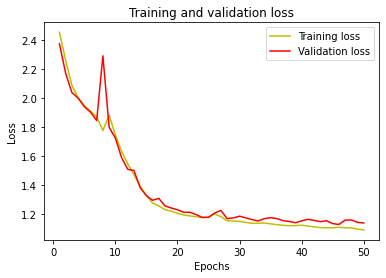

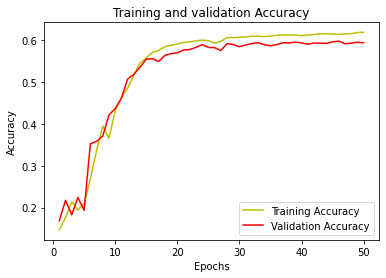

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.load_weights('test.hdf5')  

#### 3. Prediction on few images

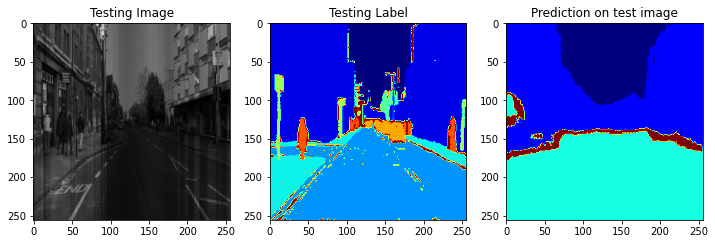

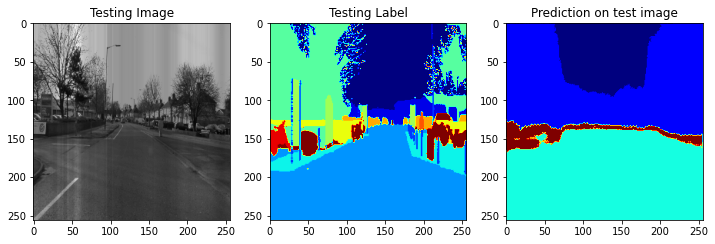

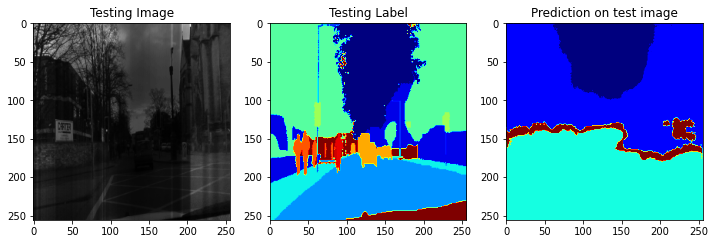

In [ ]:
#Predict on a few images

import random

# No. of images to prdict 
i=[1,2,3]

for n in i:
  test_img_number = random.randint(0, len(X_test))
  test_img = X_test[test_img_number]
  ground_truth=y_test[test_img_number]
  test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img_norm, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]


  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,0], cmap='gray')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth[:,:,0], cmap='jet')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img, cmap='jet')
  plt.show()

## Architecture 02- Using ASPP

### Developing the model and compiling

In [ ]:
from keras.models import Model
from keras.layers import Input, SeparableConv2D,Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
#Build the model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255)(inputs)   #normalize our inputs
s = inputs

#Downsampling
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)
    
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

#Adding Separable Convolution
c3 = SeparableConv2D(32, (3, 3), activation='relu', dilation_rate=2 ,kernel_initializer='he_normal', padding='same')(p2)

s1 = SeparableConv2D(32, (1, 1), activation='relu',kernel_initializer='he_normal', padding='same')(c3)
s2 = SeparableConv2D(32, (3, 3), activation='relu', dilation_rate=6 ,kernel_initializer='he_normal', padding='same')(c3)
s3 = SeparableConv2D(32, (3, 3), activation='relu', dilation_rate=12 ,kernel_initializer='he_normal', padding='same')(c3)
s4 = SeparableConv2D(32, (3, 3), activation='relu', dilation_rate=18 ,kernel_initializer='he_normal', padding='same')(c3)
#p3 = MaxPooling2D((2, 2), padding='same')(c3)

c4 = concatenate([s1 ,s2, s3, s4])
c5 = Conv2D(32, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2, 2), padding='same')(c5)

#aspp_output=_build_atrous_spatial_pyramid_pooling(p2, depth=32)
# c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
# c3 = Dropout(0.2)(c3)
# c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
# p3 = MaxPooling2D((2, 2))(c3)
     
# c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
# c4 = Dropout(0.2)(c4)
# c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
# p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
# c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
# c5 = Dropout(0.3)(c5)
# c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
#Upsampling 
# u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
# u6 = concatenate([u6, c4])
# c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
# c6 = Dropout(0.2)(c6)
# c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
# u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
# u7 = concatenate([u7, c3])
# c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
# c7 = Dropout(0.2)(c7)
# c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c6 = Dropout(0.3)(c5)
c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
     
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
model2 = Model(inputs=[inputs], outputs=[outputs])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

### Fitting the model

In [ ]:
history2 = model2.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False
                    )
                    


model.save('test2.hdf5')

Epoch 1/50
21/21 [==============================] - 12s 391ms/step - loss: 2.3376 - accuracy: 0.1714 - val_loss: 2.1883 - val_accuracy: 0.3057
Epoch 2/50
21/21 [==============================] - 7s 349ms/step - loss: 2.1115 - accuracy: 0.3139 - val_loss: 1.9231 - val_accuracy: 0.3129
Epoch 3/50
21/21 [==============================] - 7s 350ms/step - loss: 1.7536 - accuracy: 0.4173 - val_loss: 1.5991 - val_accuracy: 0.4611
Epoch 4/50
21/21 [==============================] - 7s 351ms/step - loss: 1.4923 - accuracy: 0.5093 - val_loss: 1.3961 - val_accuracy: 0.5517
Epoch 5/50
21/21 [==============================] - 7s 352ms/step - loss: 1.3710 - accuracy: 0.5462 - val_loss: 1.3166 - val_accuracy: 0.5473
Epoch 6/50
21/21 [==============================] - 7s 350ms/step - loss: 1.2926 - accuracy: 0.5703 - val_loss: 1.2719 - val_accuracy: 0.5567
Epoch 7/50
21/21 [==============================] - 7s 350ms/step - loss: 1.2696 - accuracy: 0.5777 - val_loss: 1.2679 - val_accuracy: 0.5707
Epoch

In [ ]:
#model2.load_weights('test2.hdf5') 

### Evaluating the model

#### Accuracy

In [ ]:
#Evaluate the model
	# evaluate model
_, acc = model2.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

2/2 [==============================] - 0s 58ms/step - loss: 1.1158 - accuracy: 0.5977
Accuracy is =  59.77247357368469 %


#### Loss and Accuracy Graphs

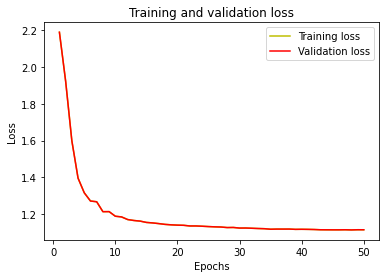

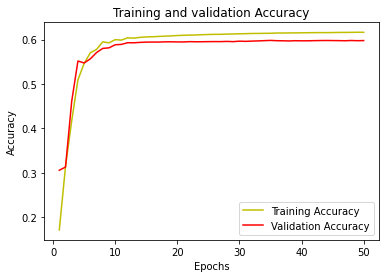

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs2 = range(1, len(loss2) + 1)
plt.plot(epochs2, val_loss2, 'y', label='Training loss')
plt.plot(epochs2, val_loss2, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

plt.plot(epochs2, acc2, 'y', label='Training Accuracy')
plt.plot(epochs2, val_acc2, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Prediction of Few images

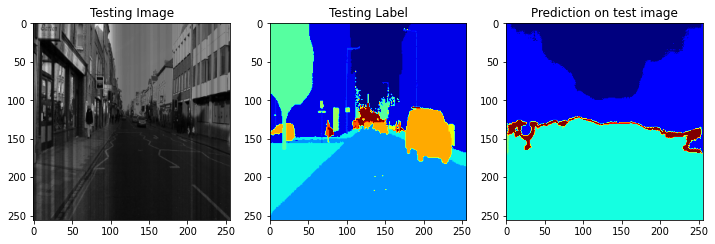

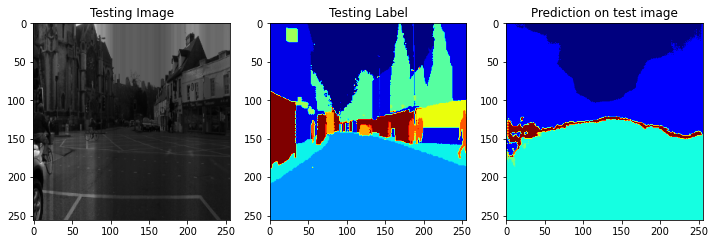

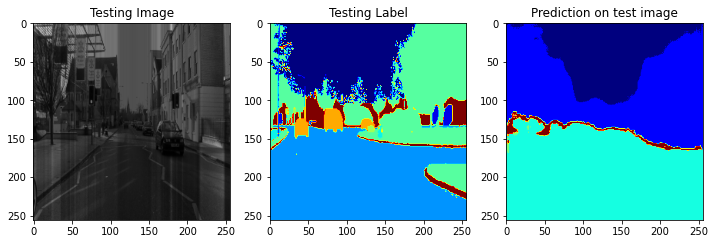

In [ ]:
#Predict on a few images

import random

# No. of images to prdict 
i=[1,2,3]

for n in i:
  test_img_number = random.randint(0, len(X_test))
  test_img = X_test[test_img_number]
  ground_truth=y_test[test_img_number]
  test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img_norm, 0)
  prediction = (model2.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]


  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,0], cmap='gray')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth[:,:,0], cmap='jet')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img, cmap='jet')
  plt.show()